In [86]:
import pyranges as pr
import pandas as pd
from Bio import SeqIO
import numpy as np
from pathlib import Path

# for model testing/analysis
import torch
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns

import sk_model2 as sam # I moved all of Sam's functions here
import model_data_generation as dat # I moved all of the data/label gen here

In [87]:
dat.TEST_CHRS = ['3L']
dat.TRAIN_CHRS = ['2L', '3R', 'X', '2R']

In [88]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.fallback'] = 'None'

In [89]:
plt.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

#### Load peaks file ... output of macs2

In [90]:
#WORKDIR = Path('/ru-auth/local/home/ezheng/scratch/SK_ML_ATAC/comp_genomics/2tis/')原来的路径

WORKDIR = Path('/rugpfs/fs0/zhao_lab/scratch/xwu05/fig3_regenerate/fig3')


DF containing positive peak examples -- coordinates

In [91]:
mel_pos_peaks = dat.load_merged_peak(WORKDIR/'Dmel.merged.narrowPeak',
                     chromosome=dat.TEST_CHRS)
# pos_peaks = pos_peaks.sample(1000) # consider down-sampling

sim_in_mel = dat.load_merged_peak(WORKDIR/'pangen.merged.unique.sim_to_mel.narrowPeak',
                     chromosome=dat.TEST_CHRS)
sim_in_mel.label1 = 0
sim_in_mel.label2 = 0 # neg peaks assuming you believe uniqueness

sim_in_sim = dat.load_merged_peak(WORKDIR/'pangen.merged.unique.sim_to_sim.narrowPeak',
                     chromosome=dat.TEST_CHRS) # pos peaks by definition
sim_in_sim

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qValue,peak,mp,label1,label2
1144,3L,52894,53894,w501_peak_9991_testis,NaN,NaN,NaN,NaN,NaN,NaN,53393.5,0,1
1145,3L,58962,59962,w501_peak_9992_head,NaN,NaN,NaN,NaN,NaN,NaN,59462.0,1,0
1146,3L,64269,65269,w501_peak_9993_merged,NaN,NaN,NaN,NaN,NaN,NaN,64768.5,1,1
1147,3L,68779,69779,w501_peak_9994_testis,NaN,NaN,NaN,NaN,NaN,NaN,69279.0,0,1
1148,3L,88653,89653,w501_peak_10004_testis,NaN,NaN,NaN,NaN,NaN,NaN,89153.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,3L,22217902,22218902,w501_peak_15121_head,NaN,NaN,NaN,NaN,NaN,NaN,22218402.0,1,0
1628,3L,22261479,22262479,w501_peak_15132_head,NaN,NaN,NaN,NaN,NaN,NaN,22261979.0,1,0
1629,3L,22304599,22305599,w501_peak_15140_head,NaN,NaN,NaN,NaN,NaN,NaN,22305098.5,1,0
1630,3L,22315794,22316794,w501_peak_15143_testis,NaN,NaN,NaN,NaN,NaN,NaN,22316294.0,0,1


In [92]:
mel_in_sim = dat.load_merged_peak(WORKDIR/'pangen.merged.unique.mel_to_sim.narrowPeak',
                     chromosome=dat.TEST_CHRS)
mel_in_sim.label1 = 0
mel_in_sim.label2 = 0 # neg peaks assuming you believe uniqueness

mel_in_mel = dat.load_merged_peak(WORKDIR/'pangen.merged.unique.mel_to_mel.narrowPeak',
                     chromosome=dat.TEST_CHRS) # pos peaks by definition

In [93]:
mel_in_yak = dat.load_merged_peak(WORKDIR/'pangen.merged.unique.mel_to_yak.narrowPeak',
                     chromosome=dat.TEST_CHRS)
mel_in_yak.label1 = 0
mel_in_yak.label2 = 0 # neg peaks assuming you believe uniqueness

sim_in_yak = dat.load_merged_peak(WORKDIR/'pangen.merged.unique.sim_to_yak.narrowPeak',
                     chromosome=dat.TEST_CHRS)
sim_in_yak.label1 = 0
sim_in_yak.label2 = 0 # neg peaks assuming you believe uniqueness


yak_in_yak = dat.load_merged_peak(WORKDIR/'pangen.merged.unique.yak_to_yak.narrowPeak',
                     chromosome=dat.TEST_CHRS) # pos peaks by definition

yak_in_mel = dat.load_merged_peak(WORKDIR/'pangen.merged.unique.yak_to_mel.narrowPeak',
                     chromosome=dat.TEST_CHRS)
yak_in_mel.label1 = 0
yak_in_mel.label2 = 0 # neg peaks assuming you believe uniqueness

yak_in_sim = dat.load_merged_peak(WORKDIR/'pangen.merged.unique.yak_to_sim.narrowPeak',
                     chromosome=dat.TEST_CHRS)
yak_in_sim.label1 = 0
yak_in_sim.label2 = 0 # neg peaks assuming you believe uniqueness

In [94]:
mel_cons_mel = dat.load_merged_peak(WORKDIR/'pangen.merged.conserved.mel_to_mel.narrowPeak',
                     chromosome=dat.TEST_CHRS)
sim_cons_sim = dat.load_merged_peak(WORKDIR/'pangen.merged.conserved.sim_to_sim.narrowPeak',
                     chromosome=dat.TEST_CHRS)
yak_cons_yak = dat.load_merged_peak(WORKDIR/'pangen.merged.conserved.yak_to_yak.narrowPeak',
                     chromosome=dat.TEST_CHRS)

In [95]:
yak_cons_yak

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qValue,peak,mp,label1,label2
5794,3L,17608,18608,Ta18_peak_9117_testis,NaN,NaN,NaN,NaN,NaN,NaN,18107.5,0,1
5795,3L,40045,41045,Ta18_peak_9122_head,NaN,NaN,NaN,NaN,NaN,NaN,40545.0,1,0
5796,3L,65031,66031,Ta18_peak_9127_testis,NaN,NaN,NaN,NaN,NaN,NaN,65531.0,0,1
5797,3L,68751,69751,Ta18_peak_9129_testis,NaN,NaN,NaN,NaN,NaN,NaN,69251.0,0,1
5798,3L,92116,93116,Ta18_peak_9135_testis,NaN,NaN,NaN,NaN,NaN,NaN,92615.5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8775,3L,23364331,23365331,Ta18_peak_13761_merged,NaN,NaN,NaN,NaN,NaN,NaN,23364831.0,1,1
8776,3L,23371368,23372368,Ta18_peak_13762_merged,NaN,NaN,NaN,NaN,NaN,NaN,23371867.5,1,1
8777,3L,23397235,23398235,Ta18_peak_13764_merged,NaN,NaN,NaN,NaN,NaN,NaN,23397734.5,1,1
8778,3L,23436299,23437299,Ta18_peak_13768_merged,NaN,NaN,NaN,NaN,NaN,NaN,23436799.0,1,1


In [96]:
outpos_peaks = dat.load_peak(WORKDIR/'pangen.merged.conserved.sim_to_sim.narrowPeak', 
                     label1 = 1, label2 = 1, chromosome=dat.TEST_CHRS) # by definition, pos peaks should all be 1
outpos_peaks

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qValue,peak,mp,label1,label2
5883,3L,33140,34140,w501_peak_9988_testis,NaN,NaN,NaN,NaN,NaN,NaN,33640.0,1,1
5884,3L,52255,53255,w501_peak_9990_merged,NaN,NaN,NaN,NaN,NaN,NaN,52754.5,1,1
5885,3L,70263,71263,w501_peak_9996_merged,NaN,NaN,NaN,NaN,NaN,NaN,70762.5,1,1
5886,3L,73502,74502,w501_peak_9998_merged,NaN,NaN,NaN,NaN,NaN,NaN,74001.5,1,1
5887,3L,82719,83719,w501_peak_10001_merged,NaN,NaN,NaN,NaN,NaN,NaN,83218.5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8564,3L,22430857,22431857,w501_peak_15154_merged,NaN,NaN,NaN,NaN,NaN,NaN,22431357.0,1,1
8565,3L,22459752,22460752,w501_peak_15159_head,NaN,NaN,NaN,NaN,NaN,NaN,22460251.5,1,1
8566,3L,22463207,22464207,w501_peak_15161_head,NaN,NaN,NaN,NaN,NaN,NaN,22463706.5,1,1
8567,3L,23701863,23702863,w501_peak_15277_merged,NaN,NaN,NaN,NaN,NaN,NaN,23702363.0,1,1


In [97]:
# keep only those species-specific peaks that are BOTH on the test chrs
sim_in_mel_t = sim_in_mel.pipe(lambda df:
                             df[ df.name.isin(sim_in_sim.name)
                               & df.name.isin(sim_in_mel.name)
                               & df.name.isin(sim_in_yak.name)])

sim_in_sim_t = sim_in_sim.pipe(lambda df:
                             df[ df.name.isin(sim_in_sim.name)
                               & df.name.isin(sim_in_mel.name)
                               & df.name.isin(sim_in_yak.name)])

sim_in_yak_t = sim_in_yak.pipe(lambda df:
                             df[ df.name.isin(sim_in_sim.name)
                               & df.name.isin(sim_in_mel.name)
                               & df.name.isin(sim_in_yak.name)])

sim_in_mel = sim_in_mel_t
sim_in_sim = sim_in_sim_t 
sim_in_yak = sim_in_yak_t # avoid race conditions
sim_in_mel

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qValue,peak,mp,label1,label2
1144,3L,73719,74719,w501_peak_9991_testis,NaN,NaN,NaN,NaN,NaN,NaN,74218.5,0,0
1145,3L,79873,80873,w501_peak_9992_head,NaN,NaN,NaN,NaN,NaN,NaN,80373.0,0,0
1146,3L,84930,85930,w501_peak_9993_merged,NaN,NaN,NaN,NaN,NaN,NaN,85430.0,0,0
1147,3L,88856,89856,w501_peak_9994_testis,NaN,NaN,NaN,NaN,NaN,NaN,89356.0,0,0
1148,3L,119163,120163,w501_peak_10004_testis,NaN,NaN,NaN,NaN,NaN,NaN,119663.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,3L,22800520,22801520,w501_peak_15109_testis,NaN,NaN,NaN,NaN,NaN,NaN,22801019.5,0,0
1627,3L,22841012,22842012,w501_peak_15121_head,NaN,NaN,NaN,NaN,NaN,NaN,22841511.5,0,0
1628,3L,22883498,22884498,w501_peak_15132_head,NaN,NaN,NaN,NaN,NaN,NaN,22883997.5,0,0
1629,3L,22924485,22925485,w501_peak_15140_head,NaN,NaN,NaN,NaN,NaN,NaN,22924985.0,0,0


In [98]:
# keep only those species-specific peaks that are BOTH on the test chrs
mel_in_mel_t = mel_in_mel.pipe(lambda df:
                             df[ df.name.isin(mel_in_mel.name)
                               & df.name.isin(mel_in_sim.name)
                               & df.name.isin(mel_in_yak.name)])

mel_in_sim_t = mel_in_sim.pipe(lambda df:
                             df[ df.name.isin(mel_in_mel.name)
                               & df.name.isin(mel_in_sim.name)
                               & df.name.isin(mel_in_yak.name)])

mel_in_yak_t = mel_in_yak.pipe(lambda df:
                             df[ df.name.isin(mel_in_mel.name)
                               & df.name.isin(mel_in_sim.name)
                               & df.name.isin(mel_in_yak.name)])

mel_in_sim = mel_in_sim_t
mel_in_mel = mel_in_mel_t 
mel_in_yak = mel_in_yak_t # avoid race conditions

In [99]:
# keep only those species-specific peaks that are BOTH on the test chrs
yak_in_mel_t = yak_in_mel.pipe(lambda df:
                             df[ df.name.isin(yak_in_mel.name)
                               & df.name.isin(yak_in_sim.name)
                               & df.name.isin(yak_in_yak.name)])

yak_in_sim_t = yak_in_sim.pipe(lambda df:
                             df[ df.name.isin(yak_in_mel.name)
                               & df.name.isin(yak_in_sim.name)
                               & df.name.isin(yak_in_yak.name)])

yak_in_yak_t = yak_in_yak.pipe(lambda df:
                             df[ df.name.isin(yak_in_mel.name)
                               & df.name.isin(yak_in_sim.name)
                               & df.name.isin(yak_in_yak.name)])

yak_in_sim = yak_in_sim_t
yak_in_mel = yak_in_mel_t 
yak_in_yak = yak_in_yak_t # avoid race conditions

### Load reference genome

In [100]:
Dmel = {}
with open("../dmel-all-chromosome-r6.41.fasta", "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        key = record.id.replace('Scf_', '')
        Dmel[key] = record.seq
        
Dsim = {}
with open("../dsim-all-chromosome-r2.02.fasta", "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        key = record.id.replace('Scf_', '')
        Dsim[key] = record.seq

Dyak = {}
with open("../dyak-all-chromosome-r1.05.fasta", "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        key = record.id.replace('Scf_', '')
        Dyak[key] = record.seq
        
Dmel

{'2L': Seq('CGACAATGCACGACAGAGGAAGCAGAACAGATATTTAGATTGCCTCTCATTTTC...GAG'),
 '2R': Seq('CTCAAGATACCTTCTACAGATTATTTAAAGCTAGTGCACAACAACAATAAATTG...TTC'),
 '3L': Seq('TAGGGAGAAATATGATCGCGTATGCGAGAGTAGTGCCAACATATTGTGCTCTTT...TAT'),
 '3R': Seq('ACGGGACCGAGTATAGTACCAGTACGCGACCAGTACGGGAGCAGTACGGAACCA...TTC'),
 '4': Seq('TTATTATATTATTATATTATTATATTATTATATTATTATATTATTATATTATTA...GAA'),
 'X': Seq('GAATTCGTCAGAAATGAGCTAAACAAATTTAAATCATTAAATGCGAGCGGCGAA...TAC'),
 'Y': Seq('GCGTTGTGAGCAACGACACTGAAAGCAACAATAATATTGTTAATTACTGCTCAA...TTC'),
 '2Cen_mapped_Scaffold_10_D1684': Seq('CTTTTCGTACTTCATCATTTGTTATGACTTCATATACGTTGGGCTTAGATACAT...AAT'),
 '2Cen_mapped_Scaffold_43_D1668': Seq('CTGCAAAACCCTCGGTATTCGCTGGAAAGCAACCTCCGACGAATTCTTCTTCGT...TAT'),
 '2R2_mapped_Scaffold_56_D1828': Seq('GATCAATTTGCGTAGATTTATCACGGCAATCAAGTTGGTTAACCTGACTAAGGG...ATC'),
 '3Cen_mapped_Scaffold_1_D1896_D1895': Seq('AGAGCCCAAACTATTGCCAACAATCCTTTTTTATTTGTGGCATAGAGTTGTTCG...CAC'),
 '3Cen_mapped_Scaffold_27_D1777': Seq('CTGGTTCTGTACTCGA

Use chromosome 3L for testing only. This is a conserved mueller element so it should be syntenic between the three species.

In [101]:
_ = dat.read_narrowPeak(WORKDIR/'Dmel.merged.narrowPeak').rename({'chrom':'Chromosome', 'chromStart':'Start', 'chromEnd':'End'}, axis=1)
_ = pr.PyRanges(_)
mel_neg_peaks = dat.generate_negatives(dat.TEST_CHRS, tile_size=dat.FEATURE_WIDTH, genome=Dmel, mpeaks_head=_, mpeaks_testis=_)
mel_neg_peaks = mel_neg_peaks.rename({'chrom':'Chromosome', 'chromStart':'Start', 'chromEnd':'End',
                              'Chromosome':'chrom', 'Start':'chromStart', 'End':'chromEnd',
                              'label_head':'label1', 'label_testis':'label2'}, axis=1)
del _
mel_neg_peaks

/ru-auth/local/home/lzhao/anaconda3/envs/xia-ml/lib/python3.9/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/ru-auth/local/home/lzhao/anaconda3/envs/xia-ml/lib/python3.9/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/ru-auth/local/home/lzhao/anaconda3/envs/xia-ml/lib/python3.9/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pan

,chrom,chromStart,chromEnd,label1,label2
11707,3L,16852000,16853000,0,0
15973,3L,22952000,22953000,0,0
6754,3L,9857000,9858000,0,0
15199,3L,21856000,21857000,0,0
19966,3L,27249000,27250000,0,0
...,...,...,...,...,...
9372,3L,13597000,13598000,0,0
7291,3L,10584000,10585000,0,0
17728,3L,24816000,24817000,0,0
7293,3L,10586000,10587000,0,0


In [102]:
#raise ValueError ("note: this previously failed to drop peaks from 3L bc of Scf_3L ; this has been fixed as of 7/29 --EBZ")
_ = dat.read_narrowPeak(WORKDIR/'Dsim.merged.narrowPeak').rename({'chrom':'Chromosome', 'chromStart':'Start', 'chromEnd':'End'}, axis=1)
_ = _.replace({'Chromosome':{'Scf_2L': '2L', 'Scf_3L':'3L', 'Scf_2R':'2R', 'Scf_3R':'3R', 'Scf_X':'X'}})
_ = pr.PyRanges(_)
sim_neg_peaks = dat.generate_negatives(dat.TEST_CHRS, tile_size=dat.FEATURE_WIDTH, genome=Dsim, mpeaks_head=_, mpeaks_testis=_)
sim_neg_peaks = sim_neg_peaks.rename({'chrom':'Chromosome', 'chromStart':'Start', 'chromEnd':'End',
                              'Chromosome':'chrom', 'Start':'chromStart', 'End':'chromEnd',
                              'label_head':'label1', 'label_testis':'label2'}, axis=1)
del _
sim_neg_peaks

/ru-auth/local/home/lzhao/anaconda3/envs/xia-ml/lib/python3.9/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/ru-auth/local/home/lzhao/anaconda3/envs/xia-ml/lib/python3.9/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/ru-auth/local/home/lzhao/anaconda3/envs/xia-ml/lib/python3.9/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pan

,chrom,chromStart,chromEnd,label1,label2
824,3L,1439000,1440000,0,0
874,3L,1525000,1526000,0,0
51,3L,66000,67000,0,0
7294,3L,10870000,10871000,0,0
7656,3L,11447000,11448000,0,0
...,...,...,...,...,...
4829,3L,7180000,7181000,0,0
10201,3L,14829000,14830000,0,0
9372,3L,13724000,13725000,0,0
7291,3L,10867000,10868000,0,0


In [103]:
_ = dat.read_narrowPeak(WORKDIR/'Dyak.merged.narrowPeak').rename({'chrom':'Chromosome', 'chromStart':'Start', 'chromEnd':'End'}, axis=1)
_ = pr.PyRanges(_)
yak_neg_peaks = dat.generate_negatives(dat.TEST_CHRS, tile_size=dat.FEATURE_WIDTH, genome=Dyak, mpeaks_head=_, mpeaks_testis=_)
yak_neg_peaks = yak_neg_peaks.rename({'chrom':'Chromosome', 'chromStart':'Start', 'chromEnd':'End',
                              'Chromosome':'chrom', 'Start':'chromStart', 'End':'chromEnd',
                              'label_head':'label1', 'label_testis':'label2'}, axis=1)
del _
yak_neg_peaks

/ru-auth/local/home/lzhao/anaconda3/envs/xia-ml/lib/python3.9/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/ru-auth/local/home/lzhao/anaconda3/envs/xia-ml/lib/python3.9/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/ru-auth/local/home/lzhao/anaconda3/envs/xia-ml/lib/python3.9/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pan

,chrom,chromStart,chromEnd,label1,label2
17458,3L,23867000,23868000,0,0
2383,3L,3695000,3696000,0,0
1570,3L,2417000,2418000,0,0
17059,3L,23443000,23444000,0,0
9797,3L,14199000,14200000,0,0
...,...,...,...,...,...
9372,3L,13640000,13641000,0,0
7291,3L,10708000,10709000,0,0
17728,3L,24170000,24171000,0,0
7293,3L,10713000,10714000,0,0


In [104]:
_ = dat.read_narrowPeak(WORKDIR/'pangen.merged.conserved.sim_to_sim.narrowPeak').rename({'chrom':'Chromosome', 'chromStart':'Start', 'chromEnd':'End'}, axis=1)
_ = pr.PyRanges(_)
outneg_peaks = dat.generate_negatives(dat.TEST_CHRS, tile_size=dat.FEATURE_WIDTH, genome=Dsim, mpeaks_head=_, mpeaks_testis=_)
outneg_peaks = outneg_peaks.rename({'chrom':'Chromosome', 'chromStart':'Start', 'chromEnd':'End',
                              'Chromosome':'chrom', 'Start':'chromStart', 'End':'chromEnd',
                              'label_head':'label1', 'label_testis':'label2'}, axis=1)
del _
outneg_peaks

/ru-auth/local/home/lzhao/anaconda3/envs/xia-ml/lib/python3.9/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/ru-auth/local/home/lzhao/anaconda3/envs/xia-ml/lib/python3.9/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}
/ru-auth/local/home/lzhao/anaconda3/envs/xia-ml/lib/python3.9/site-packages/pyranges/methods/init.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pan

,chrom,chromStart,chromEnd,label1,label2
14499,3L,14499000,14500000,0,0
15126,3L,15126000,15127000,0,0
18393,3L,18393000,18394000,0,0
9666,3L,9666000,9667000,0,0
1716,3L,1716000,1717000,0,0
...,...,...,...,...,...
9372,3L,9372000,9373000,0,0
7291,3L,7291000,7292000,0,0
17728,3L,17728000,17729000,0,0
7293,3L,7293000,7294000,0,0


In [105]:
mel_neg_peaks

,chrom,chromStart,chromEnd,label1,label2
11707,3L,16852000,16853000,0,0
15973,3L,22952000,22953000,0,0
6754,3L,9857000,9858000,0,0
15199,3L,21856000,21857000,0,0
19966,3L,27249000,27250000,0,0
...,...,...,...,...,...
9372,3L,13597000,13598000,0,0
7291,3L,10584000,10585000,0,0
17728,3L,24816000,24817000,0,0
7293,3L,10586000,10587000,0,0


In [106]:
X_sim, y_sim = dat.get_seqdata(sim_in_sim, Dsim)
X_mel, y_mel = dat.get_seqdata(sim_in_mel, Dmel)
X_yak, y_yak = dat.get_seqdata(sim_in_yak, Dyak)

X_spsp1 = np.concatenate([X_sim, X_mel, X_yak])
y_spsp1 = np.concatenate([y_sim, y_mel, y_yak])
print(y_spsp1)
print(X_spsp1.shape)

X_sim, y_sim = dat.get_seqdata(mel_in_sim, Dsim)
X_mel, y_mel = dat.get_seqdata(mel_in_mel, Dmel)
X_yak, y_yak = dat.get_seqdata(mel_in_yak, Dyak)

X_spsp2 = np.concatenate([X_sim, X_mel, X_yak])
y_spsp2 = np.concatenate([y_sim, y_mel, y_yak])
print(X_spsp2.shape)

X_sim, y_sim = dat.get_seqdata(yak_in_sim, Dsim)
X_mel, y_mel = dat.get_seqdata(yak_in_mel, Dmel)
X_yak, y_yak = dat.get_seqdata(yak_in_yak, Dyak)

X_spsp3 = np.concatenate([X_sim, X_mel, X_yak])
y_spsp3 = np.concatenate([y_sim, y_mel, y_yak])
print(X_spsp3.shape)

X_spsp = np.concatenate([X_spsp1, X_spsp2, X_spsp3])
y_spsp = np.concatenate([y_spsp1, y_spsp2, y_spsp3])
print(X_spsp.shape)

[[0. 1.]
 [1. 0.]
 [1. 1.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
(1452, 4, 1000)
(1308, 4, 1000)
(1809, 4, 1000)
(4569, 4, 1000)


In [107]:
mel_in_mel.shape


(436, 13)

In [108]:
gold_std = True

if gold_std:
    X_test_1, y_test_1 = dat.get_seqdata(mel_pos_peaks, Dmel)
    X_test_2, y_test_2 = dat.get_seqdata(mel_neg_peaks, Dmel)

    X_gold = np.concatenate([X_test_1, X_test_2])
    y_gold = np.concatenate([y_test_1, y_test_2])

## test models directly

In [109]:
def plot_curve(x, y, c, thres, flip=True):
    if flip: idx = np.searchsorted(np.flip(c), thres) 
    # finds the idx (from the opp. direction)
    # of the ~ pt near by the threshold value
    else: 
        idx = np.searchsorted(c, thres)
        c = np.flip(c)

    plt.scatter(x, y, c=c, vmax=1, s=1)

    # draw the x-y lines
    idx_x = x[-idx]
    idx_y = y[-idx]
    plt.scatter(idx_x, idx_y, s=20, color='red')
    plt.axvline(idx_x, color='black', linestyle='dotted')
    plt.axhline(idx_y, color='black', linestyle='dotted')
    print(idx_x, idx_y)

    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.colorbar(label='threshold')
    
    return plt.gca()

In [110]:
import os
#os.set_

## main fig

In [111]:
HEAD = 0
TEST = 1

In [112]:
assert (mel_in_mel.name == mel_in_yak.name).all()
assert (mel_in_mel.name == mel_in_sim.name).all()

assert (sim_in_sim.name == sim_in_mel.name).all()
assert (sim_in_sim.name == sim_in_yak.name).all()

assert (yak_in_yak.name == yak_in_mel.name).all()
assert (yak_in_yak.name == yak_in_sim.name).all()

In [113]:
X_sim, y_sim = dat.get_seqdata(mel_in_sim, Dsim)
X_yak, y_yak = dat.get_seqdata(mel_in_yak, Dyak)
X_mel, y_mel = dat.get_seqdata(mel_in_mel, Dmel)

X_spsp1 = np.concatenate([X_sim, X_yak, X_mel])
y_spsp1 = np.concatenate([y_sim, y_yak, y_mel])
print(X_spsp1.shape)

X_sim, y_sim = dat.get_seqdata(sim_in_sim, Dsim)
X_mel, y_mel = dat.get_seqdata(sim_in_mel, Dmel)
X_yak, y_yak = dat.get_seqdata(sim_in_yak, Dyak)

X_spsp2 = np.concatenate([X_mel, X_yak, X_sim])
y_spsp2 = np.concatenate([y_mel, y_yak, y_sim])
print(X_spsp2.shape)

X_sim, y_sim = dat.get_seqdata(yak_in_sim, Dsim)
X_mel, y_mel = dat.get_seqdata(yak_in_mel, Dmel)
X_yak, y_yak = dat.get_seqdata(yak_in_yak, Dyak)

X_spsp3 = np.concatenate([X_sim, X_mel, X_yak])
y_spsp3 = np.concatenate([y_sim, y_mel, y_yak])
print(X_spsp3.shape)

X_spsp = np.concatenate([X_spsp1, X_spsp2, X_spsp3])
y_spsp = np.concatenate([y_spsp1, y_spsp2, y_spsp3])
print(X_spsp.shape)

(1308, 4, 1000)
(1452, 4, 1000)
(1809, 4, 1000)
(4569, 4, 1000)


In [114]:
gold_std = True

if gold_std:
    X_test_1, y_test_1 = dat.get_seqdata(mel_cons_mel,  Dmel)
    X_test_2, y_test_2 = dat.get_seqdata(mel_neg_peaks, Dmel)

    X_gold_mel = np.concatenate([X_test_1, X_test_2])
    y_gold_mel = np.concatenate([y_test_1, y_test_2])
    
    X_test_1, y_test_1 = dat.get_seqdata(sim_cons_sim,  Dsim)
    X_test_2, y_test_2 = dat.get_seqdata(sim_neg_peaks, Dsim)

    X_gold_sim = np.concatenate([X_test_1, X_test_2])
    y_gold_sim = np.concatenate([y_test_1, y_test_2])

    X_test_1, y_test_1 = dat.get_seqdata(yak_cons_yak,  Dyak)
    X_test_2, y_test_2 = dat.get_seqdata(yak_neg_peaks, Dyak)

    X_gold_yak = np.concatenate([X_test_1, X_test_2])
    y_gold_yak = np.concatenate([y_test_1, y_test_2])

In [115]:
# this is where we load the trained model

mel_model = sam.load_model('dmel_3L', param_suffix='3L')
sim_model = sam.load_model('dsim_3L', param_suffix='3L')
yak_model = sam.load_model('dyak_3L', param_suffix='3L')
mel_model

/ru-auth/local/home/lzhao/anaconda3/envs/xia-ml/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


NeuralNetwork(
  (convlayers): Sequential(
    (0): Conv1d(4, 250, kernel_size=(6,), stride=(1,))
    (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(250, 250, kernel_size=(6,), stride=(1,))
    (5): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(250, 250, kernel_size=(6,), stride=(1,))
    (9): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(250, 250, kernel_size=(6,), stride=(1,))
    (13): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool1d(kernel_size=2, stride=2, paddi

In [116]:
rawresult_spsp1 = sam.inference(X_spsp1, y_spsp1, mel_model)
rawresult_spsp2 = sam.inference(X_spsp2, y_spsp2, sim_model)
rawresult_spsp3 = sam.inference(X_spsp3, y_spsp3, yak_model)
rawresult_spsp1

[{'head_out': tensor([2.0761e-01, 4.7398e-01, 2.9459e-02, 2.0521e-01, 9.2890e-02, 4.6621e-02,
          2.0976e-01, 1.6198e-01, 8.8410e-03, 5.3923e-01, 7.1756e-02, 1.0677e-03,
          5.0694e-02, 3.1564e-01, 1.1826e-01, 3.1527e-04, 6.8620e-03, 2.0946e-01,
          2.4827e-02, 2.2932e-02, 4.4412e-01, 3.0115e-01, 1.6172e-03, 3.9460e-01,
          4.6582e-01, 1.0030e-02, 1.5893e-02, 7.6120e-01, 3.0022e-02, 9.5354e-01,
          7.9052e-03, 2.3818e-02, 2.6674e-03, 8.2031e-04, 4.4060e-01, 8.5681e-04,
          4.1024e-02, 1.4710e-04, 2.8170e-01, 3.1409e-01, 1.7840e-01, 6.4177e-01,
          8.5626e-02, 3.3326e-02, 2.9326e-01, 2.0747e-02, 6.2155e-01, 9.1866e-01,
          1.1577e-01, 2.8026e-01, 4.4373e-05, 1.7977e-02, 3.5344e-01, 4.0787e-01,
          7.5488e-02, 6.2876e-02, 1.0476e-03, 1.0613e-01, 9.3210e-02, 6.7377e-01,
          7.9237e-02, 2.6147e-03, 6.5622e-01, 2.7826e-02, 3.4543e-01, 3.1263e-01,
          9.5065e-03, 6.4376e-01, 2.8870e-01, 2.1133e-01, 9.8909e-02, 3.9998e-02,
    

In [117]:
rawresult_gold_mel = sam.inference(X_gold_mel, y_gold_mel, mel_model)
rawresult_gold_sim = sam.inference(X_gold_sim, y_gold_sim, sim_model)
rawresult_gold_yak = sam.inference(X_gold_yak, y_gold_yak, yak_model)
rawresult_gold_mel

[{'head_out': tensor([6.9761e-01, 4.4730e-01, 6.7665e-02, 3.9078e-01, 6.4802e-01, 9.2858e-01,
          8.8815e-01, 7.1599e-01, 9.6322e-01, 1.3910e-01, 9.9976e-01, 9.8677e-01,
          4.6392e-01, 1.2748e-02, 8.3391e-01, 3.2391e-01, 1.3604e-01, 7.0685e-01,
          2.6391e-04, 2.8745e-01, 5.2537e-01, 9.9572e-01, 9.8587e-01, 9.2385e-01,
          3.8631e-01, 9.5976e-01, 6.4942e-01, 1.0680e-02, 4.5789e-01, 8.9080e-01,
          5.2762e-01, 1.0786e-01, 3.2884e-02, 7.2955e-01, 8.7766e-01, 5.6781e-01,
          9.9948e-01, 7.2435e-01, 7.9958e-01, 9.3372e-01, 4.8959e-02, 1.3763e-01,
          3.6055e-01, 9.9880e-01, 9.8589e-01, 9.9976e-01, 1.1713e-02, 3.7026e-01,
          9.3659e-01, 4.8504e-01, 5.7496e-02, 9.9999e-01, 9.9881e-01, 4.0187e-01,
          4.2051e-01, 2.9982e-02, 8.7830e-01, 9.2069e-01, 8.4583e-01, 1.3396e-03,
          4.4898e-01, 9.8993e-02, 6.3709e-01, 3.8887e-02, 7.3798e-01, 9.8958e-01,
          8.9382e-01, 1.1937e-02, 1.2375e-01, 9.5895e-01, 3.7511e-01, 9.0251e-01,
    

In [118]:
def construct_filter_nway_idxs(tissue, context, y):
    # avoids leakage of opposite-tissue specific peaks into the analysis

    if tissue=='head':
        col = 'label1'
        n = 0
    elif tissue=='testis':
        col= 'label2'
        n=1
    else: raise ValueError
    assert context in ['mel', 'sim', 'yak']
    ref_df = {'mel':mel_in_mel,
              'sim':sim_in_sim,
              'yak':yak_in_yak}[context]
    
    idxs = (ref_df.reset_index(drop=True)
        #(yak_in_yak[yak_in_yak.name.isin(yak_Xtra_paranoid)].reset_index(drop=True)
            .pipe(lambda df: df[df[col]==1]).index.values)
    
    offset = ref_df.shape[0]
    assert y.shape[0] == 3*offset, (y.shape, offset)
    #idxs = [5, 24, 30, 118, 119, 131, 133, 136, 141, 179, 199, 243, 244]
    pos_idxs = [i+2*offset for i in idxs]
    neg_idxs = [i+0*offset for i in idxs] + [i+1*offset for i in idxs]
    assert all([i[n] == 1 for i in y[pos_idxs]])
    assert all([i[n] == 0 for i in y[neg_idxs]])
    return pos_idxs, neg_idxs


## extract model trios and performance

In [119]:
mel_in_mel.shape

(436, 13)

In [120]:
mel_in_mel.pipe(lambda df: df[df.label1.astype(bool)])

,chrom,chromStart,chromEnd,name,score,strand,signalValue,pValue,qValue,peak,mp,label1,label2
1087,3L,50432,51432,2057_peak_9303_head,NaN,NaN,NaN,NaN,NaN,NaN,50931.5,1,0
1094,3L,355381,356381,2057_peak_9379_merged,NaN,NaN,NaN,NaN,NaN,NaN,355880.5,1,1
1095,3L,355988,356988,2057_peak_9380_head,NaN,NaN,NaN,NaN,NaN,NaN,356487.5,1,0
1104,3L,555760,556760,2057_peak_9419_head,NaN,NaN,NaN,NaN,NaN,NaN,556259.5,1,0
1105,3L,565912,566912,2057_peak_9425_head,NaN,NaN,NaN,NaN,NaN,NaN,566412.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,3L,19571872,19572872,2057_peak_13552_head,NaN,NaN,NaN,NaN,NaN,NaN,19572372.0,1,0
1511,3L,19890071,19891071,2057_peak_13611_head,NaN,NaN,NaN,NaN,NaN,NaN,19890571.0,1,0
1519,3L,22327200,22328200,2057_peak_14123_head,NaN,NaN,NaN,NaN,NaN,NaN,22327700.0,1,0
1520,3L,22344244,22345244,2057_peak_14131_head,NaN,NaN,NaN,NaN,NaN,NaN,22344743.5,1,0


In [121]:
def scan_trios(ser):
    o = int(ser.shape[0]/3)
    trios = []
    for i in range(o):
        trio = ser.iloc[[i, o+i, 2*o+i]]
        trios.append(trio.reset_index(drop=True))
        
        #if trio.argmax() == 2:
        #    print (i, trio)
    return np.array(trios)

In [122]:
execute = True

In [123]:
# correct mel-specific gains, head
ser = sam.parse_bulk_results(rawresult_spsp1, labels=True)[HEAD][0].reset_index(drop=True)
print(ser)
column = 'label1'
trios = pd.DataFrame(scan_trios(ser), columns = ['sim', 'yak', 'mel'])

df = (pd.concat([mel_in_mel.reset_index(drop=True), trios], axis=1)
      .dropna(axis=1)
      .pipe(lambda df: df.assign(correct = df.loc[:, ['mel', 'sim','yak']].idxmax(axis=1) == 'mel'))
      #.pipe(lambda df: df[df.correct])
      .pipe(lambda df: df[df[column] == 1])
      .assign(delta = lambda df: df.mel - (df.sim + df.yak)/2)
      .sort_values(by=['delta'], ascending=False)
)
if execute:
    #df.to_csv('./spsp_model_calls/mel-specific_head.csv', index=False)
    df.to_csv('/rugpfs/fs0/zhao_lab/scratch/xwu05/fig3_regenerate/fig3/mel-specific_head_3L.csv', index=False)

print(df.tail(10))
print(len(df))

0       0.207605
1       0.473985
2       0.029459
3       0.205206
4       0.092890
          ...   
1303    0.575699
1304    0.253353
1305    0.052584
1306    0.342519
1307    0.030030
Length: 1308, dtype: float32
    chrom chromStart  chromEnd                    name          mp  label1  \
105    3L    4597033   4598033    2057_peak_10365_head   4597532.5       1   
217    3L    9421046   9422046    2057_peak_11361_head   9421545.5       1   
120    3L    5312624   5313624    2057_peak_10501_head   5313124.0       1   
378    3L   17082248  17083248    2057_peak_12999_head  17082747.5       1   
74     3L    2873651   2874651     2057_peak_9968_head   2874150.5       1   
0      3L      50432     51432     2057_peak_9303_head     50931.5       1   
221    3L    9904729   9905729    2057_peak_11471_head   9905228.5       1   
391    3L   17714022  17715022    2057_peak_13154_head  17714522.0       1   
202    3L    8210131   8211131  2057_peak_11093_merged   8210631.0       1   
114 

In [124]:
ser = sam.parse_bulk_results(rawresult_spsp1, labels=True)[TEST][0].reset_index(drop=True)
column = 'label2'
trios = pd.DataFrame(scan_trios(ser), columns = ['sim', 'yak', 'mel'])

df = (pd.concat([mel_in_mel.reset_index(drop=True), trios], axis=1)
      .dropna(axis=1)
      .pipe(lambda df: df.assign(correct = df.loc[:, ['mel', 'sim','yak']].idxmax(axis=1) == 'mel'))
      #.pipe(lambda df: df[df.correct])
      .pipe(lambda df: df[df[column] == 1])
      .assign(delta = lambda df: df.mel - (df.sim + df.yak)/2)
      .sort_values(by=['delta'], ascending=False)
)
if execute:
    df.to_csv('/rugpfs/fs0/zhao_lab/scratch/xwu05/fig3_regenerate/fig3/mel-specific_test_3L.csv', index=False)
df.head(10)

,chrom,chromStart,chromEnd,name,mp,label1,label2,sim,yak,mel,correct,delta
325,3L,14267061,14268061,2057_peak_12394_merged,14267560.5,1,1,0.028765,0.001481,0.995254,True,0.980130
203,3L,8238180,8239180,2057_peak_11096_merged,8238680.0,1,1,0.013401,0.060637,0.774220,True,0.737201
38,3L,1424401,1425401,2057_peak_9656_merged,1424901.0,1,1,0.027756,0.101599,0.768240,True,0.703562
2,3L,88303,89303,2057_peak_9307_testis,88802.5,0,1,0.063452,0.035202,0.674026,True,0.624699
36,3L,1408294,1409294,2057_peak_9653_testis,1408793.5,0,1,0.141878,0.289400,0.810496,True,0.594857
78,3L,3220624,3221624,2057_peak_10032_testis,3221123.5,0,1,0.069076,0.006513,0.589441,True,0.551646
5,3L,295317,296317,2057_peak_9364_testis,295817.0,0,1,0.359499,0.198967,0.786844,True,0.507612
432,3L,22759134,22760134,2057_peak_14200_testis,22759634.0,0,1,0.151826,0.026852,0.584722,True,0.495383
297,3L,12924013,12925013,2057_peak_12158_merged,12924512.5,1,1,0.012611,0.009597,0.505768,True,0.494664
260,3L,11632961,11633961,2057_peak_11905_testis,11633461.0,0,1,0.318251,0.058629,0.665415,True,0.476975


In [125]:
# correct sim-specific gains, head
ser = sam.parse_bulk_results(rawresult_spsp2, labels=True)[HEAD][0].reset_index(drop=True)
column = 'label1'
trios = pd.DataFrame(scan_trios(ser), columns = ['mel', 'yak', 'sim'])

df = (pd.concat([sim_in_sim.reset_index(drop=True), trios], axis=1)
      .dropna(axis=1)
      .pipe(lambda df: df.assign(correct = df.loc[:, ['mel', 'sim','yak']].idxmax(axis=1) == 'sim'))
      #.pipe(lambda df: df[df.correct])
      .pipe(lambda df: df[df[column] == 1])
      .assign(delta = lambda df: df.sim - (df.mel + df.yak)/2)
      .sort_values(by=['delta'], ascending=False)
)
if execute:
    df.to_csv('/rugpfs/fs0/zhao_lab/scratch/xwu05/fig3_regenerate/fig3/sim-specific_head_3L.csv', index=False)

df.head(10)

,chrom,chromStart,chromEnd,name,mp,label1,label2,mel,yak,sim,correct,delta
213,3L,6870393,6871393,w501_peak_11675_merged,6870892.5,1,1,0.325244,0.050997,0.674725,True,0.486604
410,3L,16142360,16143360,w501_peak_13739_head,16142860.0,1,0,0.525586,0.371732,0.781613,True,0.332955
337,3L,11874476,11875476,w501_peak_12902_head,11874976.0,1,0,0.403256,0.256550,0.661713,True,0.331810
359,3L,12686949,12687949,w501_peak_13043_head,12687449.0,1,0,0.194964,0.419615,0.628275,True,0.320986
260,3L,8731265,8732265,w501_peak_12124_head,8731765.0,1,0,0.545773,0.710792,0.934293,True,0.306010
218,3L,7159842,7160842,w501_peak_11741_head,7160341.5,1,0,0.514873,0.446978,0.779554,True,0.298629
416,3L,16343631,16344631,w501_peak_13793_head,16344131.0,1,0,0.434361,0.415524,0.710857,True,0.285915
9,3L,136845,137845,w501_peak_10029_head,137344.5,1,0,0.107724,0.095338,0.363275,True,0.261744
75,3L,1721340,1722340,w501_peak_10505_head,1721839.5,1,0,0.291106,0.395950,0.589945,True,0.246417
85,3L,2236703,2237703,w501_peak_10603_head,2237203.0,1,0,0.361088,0.258208,0.554301,True,0.244653


In [126]:
# correct sim-specific gains, test
ser = sam.parse_bulk_results(rawresult_spsp2, labels=True)[TEST][0].reset_index(drop=True)
column = 'label2'
trios = pd.DataFrame(scan_trios(ser), columns = ['mel', 'yak', 'sim'])

df = (pd.concat([sim_in_sim.reset_index(drop=True), trios], axis=1)
      .dropna(axis=1)
      .pipe(lambda df: df.assign(correct = df.loc[:, ['mel', 'sim','yak']].idxmax(axis=1) == 'sim'))
      #.pipe(lambda df: df[df.correct])
      .pipe(lambda df: df[df[column] == 1])
      .assign(delta = lambda df: df.sim - (df.mel + df.yak)/2)
      .sort_values(by=['delta'], ascending=False)
)
if execute:
    df.to_csv('/rugpfs/fs0/zhao_lab/scratch/xwu05/fig3_regenerate/fig3/sim-specific_test_3L.csv', index=False)

df.head(10)

,chrom,chromStart,chromEnd,name,mp,label1,label2,mel,yak,sim,correct,delta
213,3L,6870393,6871393,w501_peak_11675_merged,6870892.5,1,1,0.254897,0.041200,0.811016,True,0.662968
142,3L,3415528,3416528,w501_peak_10948_testis,3416027.5,0,1,0.066477,0.018051,0.555067,True,0.512803
436,3L,17234278,17235278,w501_peak_14020_testis,17234778.0,0,1,0.367616,0.025636,0.583786,True,0.387160
457,3L,18241592,18242592,w501_peak_14229_testis,18242092.0,0,1,0.908542,0.153497,0.839328,False,0.308308
41,3L,745392,746392,w501_peak_10219_testis,745892.0,0,1,0.402363,0.430641,0.722842,True,0.306339
70,3L,1397503,1398503,w501_peak_10427_testis,1398003.0,0,1,0.734385,0.449704,0.886928,True,0.294883
105,3L,2534650,2535650,w501_peak_10715_testis,2535149.5,0,1,0.489925,0.540882,0.790364,True,0.274961
129,3L,3099785,3100785,w501_peak_10855_testis,3100284.5,0,1,0.105985,0.290687,0.451506,True,0.253171
332,3L,11638345,11639345,w501_peak_12858_testis,11638845.0,0,1,0.816109,0.675066,0.982266,True,0.236679
164,3L,4363100,4364100,w501_peak_11172_testis,4363600.0,0,1,0.380918,0.168723,0.501463,True,0.226642


In [127]:
# correct yak-specific gains, head
ser = sam.parse_bulk_results(rawresult_spsp3, labels=True)[HEAD][0].reset_index(drop=True)
column = 'label1'
trios = pd.DataFrame(scan_trios(ser), columns = ['sim', 'mel', 'yak'])

df = (pd.concat([yak_in_yak.reset_index(drop=True), trios], axis=1)
      .dropna(axis=1)
      .pipe(lambda df: df.assign(correct = df.loc[:, ['mel', 'sim','yak']].idxmax(axis=1) == 'yak'))
      #.pipe(lambda df: df[df.correct])
      .pipe(lambda df: df[df[column] == 1])
      .assign(delta = lambda df: df.yak - (df.sim + df.mel)/2)
      .sort_values(by=['delta'], ascending=False)
)
if execute:
    df.to_csv('/rugpfs/fs0/zhao_lab/scratch/xwu05/fig3_regenerate/fig3/yak-specific_head_3L.csv', index=False)

df.head(10)

,chrom,chromStart,chromEnd,name,mp,label1,label2,sim,mel,yak,correct,delta
190,3L,5708911,5709911,Ta18_peak_10494_merged,5709410.5,1,1,0.036105,0.012422,0.599643,True,0.575380
367,3L,11576453,11577453,Ta18_peak_11817_head,11576952.5,1,0,0.420115,0.246744,0.871941,True,0.538512
587,3L,22079539,22080539,Ta18_peak_13621_head,22080038.5,1,0,0.218176,0.462478,0.872394,True,0.532067
438,3L,13995295,13996295,Ta18_peak_12276_head,13995795.0,1,0,0.148207,0.179864,0.649866,True,0.485830
6,3L,47252,48252,Ta18_peak_9124_head,47751.5,1,0,0.068744,0.064146,0.508150,True,0.441705
497,3L,16024716,16025716,Ta18_peak_12666_merged,16025215.5,1,1,0.452508,0.452615,0.872833,True,0.420271
500,3L,16080806,16081806,Ta18_peak_12690_head,16081306.0,1,0,0.425231,0.481801,0.870613,True,0.417096
477,3L,15116088,15117088,Ta18_peak_12492_head,15116587.5,1,0,0.182127,0.117270,0.534592,True,0.384893
271,3L,8387177,8388177,Ta18_peak_11033_merged,8387677.0,1,1,0.199388,0.126134,0.538606,True,0.375845
353,3L,11218488,11219488,Ta18_peak_11715_head,11218987.5,1,0,0.068900,0.039358,0.426302,True,0.372173


In [128]:
ser = sam.parse_bulk_results(rawresult_spsp3, labels=True)[TEST][0].reset_index(drop=True)
column = 'label2'
trios = pd.DataFrame(scan_trios(ser), columns = ['sim', 'mel', 'yak'])

df = (pd.concat([yak_in_yak.reset_index(drop=True), trios], axis=1)
      .dropna(axis=1)
      .pipe(lambda df: df.assign(correct = df.loc[:, ['mel', 'sim','yak']].idxmax(axis=1) == 'yak'))
      #.pipe(lambda df: df[df.correct])
      .pipe(lambda df: df[df[column] == 1])
      .assign(delta = lambda df: df.yak - (df.sim + df.mel)/2)
      .sort_values(by=['delta'], ascending=False)
)
if execute:
    df.to_csv('/rugpfs/fs0/zhao_lab/scratch/xwu05/fig3_regenerate/fig3/yak-specific_test_3L.csv', index=False)
df.head(10)

,chrom,chromStart,chromEnd,name,mp,label1,label2,sim,mel,yak,correct,delta
358,3L,11274441,11275441,Ta18_peak_11735_testis,11274941.0,0,1,0.036485,0.072178,0.527567,True,0.473235
59,3L,1706739,1707739,Ta18_peak_9575_testis,1707239.0,0,1,0.064797,0.105600,0.556162,True,0.470963
389,3L,12201965,12202965,Ta18_peak_11957_testis,12202465.0,0,1,0.218847,0.212077,0.666681,True,0.451219
190,3L,5708911,5709911,Ta18_peak_10494_merged,5709410.5,1,1,0.052320,0.026695,0.463093,True,0.423585
296,3L,9170854,9171854,Ta18_peak_11220_testis,9171353.5,0,1,0.274175,0.247119,0.682650,True,0.422003
2,3L,21405,22405,Ta18_peak_9119_testis,21905.0,0,1,0.128123,0.009116,0.482347,True,0.413727
531,3L,17206964,17207964,Ta18_peak_12956_testis,17207463.5,0,1,0.279375,0.244812,0.656150,True,0.394057
444,3L,14252144,14253144,Ta18_peak_12320_testis,14252643.5,0,1,0.108604,0.200759,0.542538,True,0.387856
112,3L,3133574,3134574,Ta18_peak_9895_testis,3134073.5,0,1,0.107538,0.101575,0.471540,True,0.366984
480,3L,15176407,15177407,Ta18_peak_12505_testis,15176907.0,0,1,0.177571,0.172715,0.536391,True,0.361248


## figures

In [129]:
import matplotlib.cm as cm

Dark2 = cm.get_cmap('Dark2')

In [130]:
def sigbar(x1, x2, label,x_shrink=0.05, y_jitter=0, h=.03):
    #x1, x2 = 2, 3
    y = 1.04 + y_jitter
    col = 'k'
    plt.plot([x1+x_shrink, x1+x_shrink, x2-x_shrink, x2-x_shrink], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, label, ha='center', va='bottom', color=col)

In [131]:
def super_plot4(species, ax):
    gold_rr_dict = {'mel':rawresult_gold_mel,
                    'sim':rawresult_gold_sim,
                    'yak':rawresult_gold_yak}
    rr_gold = gold_rr_dict[species]
    plot_rr_dict = {'mel':rawresult_spsp1,
                    'sim':rawresult_spsp2,
                    'yak':rawresult_spsp3}
    rr_plot = plot_rr_dict[species]
    y_rr_dict    = {'mel':y_spsp1,
                    'sim':y_spsp2,
                    'yak':y_spsp3}
    y_plot =     y_rr_dict[species]
    spname = {'mel':'melanogaster',
              'sim':'simulans',
              'yak':'yakuba'}[species]
    
    pos_idxs, neg_idxs = construct_filter_nway_idxs('head', species, y_plot)
    melt_ref = pd.DataFrame([sam.parse_bulk_results(rr_gold, labels=True)[HEAD][0].reset_index(drop=True),
                  sam.parse_bulk_results(rr_gold, labels=True)[HEAD][1].reset_index(drop=True)],
                index=['output', 'label']).T
    melted = pd.DataFrame([sam.parse_bulk_results(rr_plot, labels=True)[HEAD][0].iloc[pos_idxs+neg_idxs].reset_index(drop=True),
                  sam.parse_bulk_results(rr_plot, labels=True)[HEAD][1].iloc[pos_idxs+neg_idxs].reset_index(drop=True)],
                index=['output', 'label']).T

    # ensure we don't have leakage of other-tissue -specific peaks into "orthologous non-peaks"
    assert 2 * melted[melted['label']==1].shape[0] == melted[melted['label']==0].shape[0]
    
    plt.sca(ax[0])
 
    #这段我加的   
    df_non_peaks_ref = pd.DataFrame({
    'output': melt_ref[melt_ref['label']==0]['output'],
    'category': 'non-peaks'
})
    df_non_peaks_melted = pd.DataFrame({
    'output': melted[melted['label']==0]['output'],
    'category': 'orthologous non-peaks'
})
    df_species_specific_peaks = pd.DataFrame({
    'output': melted[melted['label']==1]['output'],
    'category': 'species-specific peaks'
})
    df_conserved_peaks_ref = pd.DataFrame({
    'output': melt_ref[melt_ref['label']==1]['output'],
    'category': 'conserved peaks'
})
    df_combined = pd.concat([df_non_peaks_ref, df_non_peaks_melted, df_species_specific_peaks, df_conserved_peaks_ref], ignore_index=True)

    df_combined.to_csv(f'output3_data_head_{species}_3L.csv', index=False)
    
    
    
    
    data_for_plotting = [
        melt_ref[melt_ref['label']==0]['output'],
        melted[melted['label']==0]['output'],
        melted[melted['label']==1]['output'],
        melt_ref[melt_ref['label']==1]['output']
    ]
    sns.boxplot(data=data_for_plotting,
            showfliers=False,
            palette=Dark2.colors)
    
    plt.gca().set_xticklabels(['non-peaks', 'orthologous\nnon-peaks',
                               f'{species}-specific\npeaks', 'conserved\npeaks'],
                             rotation = 45, ha="right")
    plt.ylim(0,1.19)
    #plt.ylabel('output')
    plt.title(f'$\mathit{{D. {spname}}}$ head')
    #plt.xlim(0,1)
    
    p0 = spstats.mannwhitneyu(melt_ref[melt_ref['label']==0]['output'], 
                                melted[melted['label']  ==0]['output'], alternative='less').pvalue
    print(f'''{spname} H orthnp vs np: {p0}''')
        
    p1 = spstats.mannwhitneyu(melted[melted['label']==0]['output'], 
                              melted[melted['label']==1]['output'], alternative='less').pvalue
    print(f'''{spname} H spsppk vs orthnp: {p1}''')
    
    p2 = spstats.mannwhitneyu(melted[melted['label']    ==1]['output'],
                            melt_ref[melt_ref['label']  ==1]['output'], alternative='less').pvalue
    print(f'''{spname} H spsppk vs pk: {p2}''')
    
    if   p0 < 1e-10: l0 = '***'
    elif p0 < 0.001: l0 = '**'
    elif p0 < 0.05:  l0 = '*'
    else:            l0 = 'n.s.'
            
    if   p1 < 1e-10: l1 = '***'
    elif p1 < 0.001: l1 = '**'
    elif p1 < 0.05:  l1 = '*'
    else:            l1 = 'n.s.'
            
    if   p2 < 1e-10: l2 = '***'
    elif p2 < 0.001: l2 = '**'
    elif p2 < 0.05:  l2 = '*'
    else:            l2 = 'n.s.'

    sigbar(0, 1, l0)
    sigbar(1, 2, l1)
    sigbar(2, 3, l2)
    
    pos_idxs, neg_idxs = construct_filter_nway_idxs('testis', species, y_plot)
    melted_ref = pd.DataFrame([sam.parse_bulk_results(rr_gold, labels=True)[TEST][0].reset_index(drop=True),
                  sam.parse_bulk_results(rr_gold, labels=True)[TEST][1].reset_index(drop=True)],
                index=['output', 'label']).T
    
    melted = pd.DataFrame([sam.parse_bulk_results(rr_plot, labels=True)[TEST][0].iloc[pos_idxs+neg_idxs].reset_index(drop=True),
                  sam.parse_bulk_results(rr_plot, labels=True)[TEST][1].iloc[pos_idxs+neg_idxs].reset_index(drop=True)],
                index=['output', 'label']).T
    # ensure we don't have leakage of other-tissue -specific peaks into "orthologous non-peaks"
    assert 2 * melted[melted['label']==1].shape[0] == melted[melted['label']==0].shape[0]
    
    plt.sca(ax[1])
    data_for_plotting = [
        melt_ref[melt_ref['label']==0]['output'],
        melted[melted['label']==0]['output'],
        melted[melted['label']==1]['output'],
        melt_ref[melt_ref['label']==1]['output']
    ]
    
    #这段我加的
    df_non_peaks_melted = pd.DataFrame({
    'output': melted[melted['label']==0]['output'],
    'category': 'orthologous non-peaks'
})
    df_species_specific_peaks = pd.DataFrame({
    'output': melted[melted['label']==1]['output'],
    'category': 'species-specific peaks'
})
    df_conserved_peaks_ref = pd.DataFrame({
    'output': melt_ref[melt_ref['label']==1]['output'],
    'category': 'conserved peaks'
})
    df_combined = pd.concat([df_non_peaks_ref, df_non_peaks_melted, df_species_specific_peaks, df_conserved_peaks_ref], ignore_index=True)

    df_combined.to_csv(f'output3_data_testis_{species}_3L.csv', index=False)
    
    
    sns.boxplot(data=data_for_plotting,
            showfliers=False,
            palette=Dark2.colors)
    
    plt.gca().set_xticklabels(['non-peaks', 'orthologous\nnon-peaks',
                               f'{species}-specific\npeaks', 'conserved\npeaks'],
                             rotation = 45, ha="right")
    plt.ylim(0,1.19)
    #plt.ylabel('output')
    plt.title(f'$\mathit{{D. {spname}}}$ testis')
    #plt.xlim(0,1)
    
    p0 = spstats.mannwhitneyu(melt_ref[melt_ref['label']==0]['output'], 
                                melted[melted['label']  ==0]['output'], alternative='less').pvalue
    print(f'''{spname} T orthnp vs np: {p0}''')
    
    p1 = spstats.mannwhitneyu(melted[melted['label']==0]['output'], 
                              melted[melted['label']==1]['output'], alternative='less').pvalue
    print(f'''{spname} T spsppk vs orthnp: {p1}''')
    
    p2 = spstats.mannwhitneyu(melted[melted['label']    ==1]['output'],
                            melt_ref[melt_ref['label']  ==1]['output'], alternative='less').pvalue
    print(f'''{spname} T spsppk vs pk: {p2}''')
    
    if   p0 < 1e-10: l0 = '***'
    elif p0 < 0.001: l0 = '**'
    elif p0 < 0.05:  l0 = '*'
    else:            l0 = 'n.s.'
            
    if   p1 < 1e-10: l1 = '***'
    elif p1 < 0.001: l1 = '**'
    elif p1 < 0.05:  l1 = '*'
    else:            l1 = 'n.s.'
            
    if   p2 < 1e-10: l2 = '***'
    elif p2 < 0.001: l2 = '**'
    elif p2 < 0.05:  l2 = '*'
    else:            l2 = 'n.s.'

    sigbar(0, 1, l0)
    sigbar(1, 2, l1)
    sigbar(2, 3, l2)

In [132]:
import scipy.stats as spstats

In [133]:
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12

melanogaster H orthnp vs np: 5.082865249499683e-123
melanogaster H spsppk vs orthnp: 0.10078834440168744
melanogaster H spsppk vs pk: 1.332387944922512e-21
melanogaster T orthnp vs np: 2.856633053936645e-151
melanogaster T spsppk vs orthnp: 0.015008438037201628
melanogaster T spsppk vs pk: 2.72838833965408e-69
simulans H orthnp vs np: 1.7166189792101972e-173
simulans H spsppk vs orthnp: 0.00635613086930485
simulans H spsppk vs pk: 9.336676613742162e-32
simulans T orthnp vs np: 3.1541075189930274e-59
simulans T spsppk vs orthnp: 0.028493466232604285
simulans T spsppk vs pk: 2.8989795670853254e-80
yakuba H orthnp vs np: 3.748886803016764e-95
yakuba H spsppk vs orthnp: 2.3268620538895057e-06
yakuba H spsppk vs pk: 3.160028341766856e-11
yakuba T orthnp vs np: 6.656758090179907e-241
yakuba T spsppk vs orthnp: 4.607344869911553e-09
yakuba T spsppk vs pk: 6.238543691318565e-80


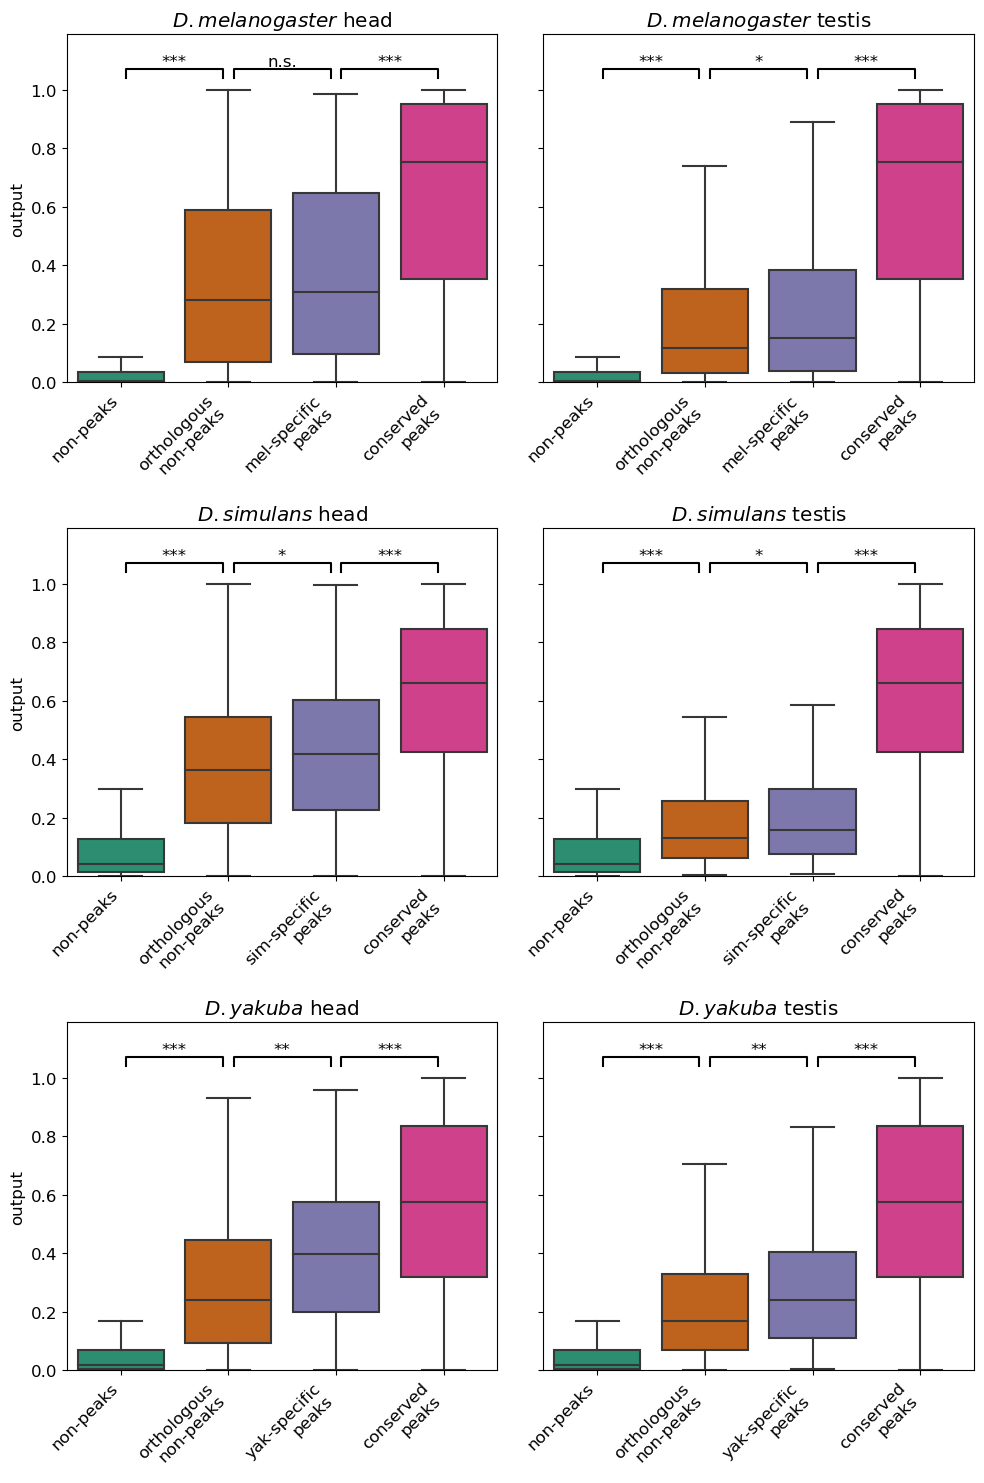

In [134]:
f, ax = plt.subplots(3,2, sharey='row', figsize=(10,15))

super_plot4('mel', [ax[0][0], ax[0][1]])
plt.sca(ax[0][0])
plt.ylabel('output')
super_plot4('sim', [ax[1][0], ax[1][1]])
plt.sca(ax[1][0])
plt.ylabel('output')
super_plot4('yak', [ax[2][0], ax[2][1]])
plt.sca(ax[2][0])
plt.ylabel('output')
plt.tight_layout()
#plt.savefig('/Users/candice/Desktop/fig3_3R_boxplot.pdf')
plt.show()

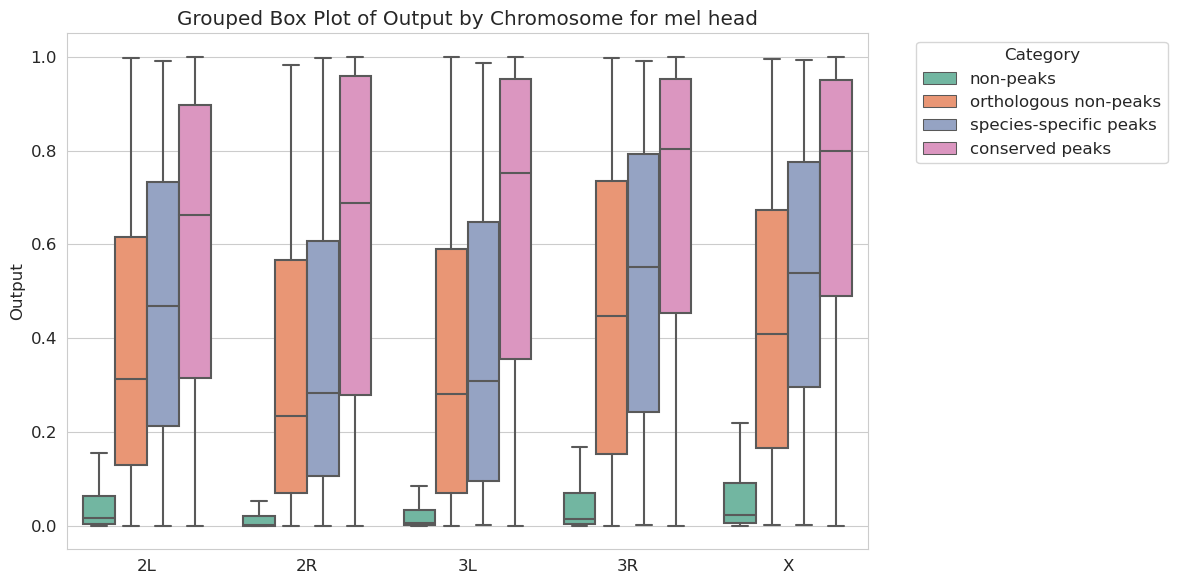

In [141]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns


species = 'mel'
tissue = 'head'
chromosome_files = glob.glob(f'output3_data_{tissue}_{species}_*.csv')


data_list = []
for file in chromosome_files:
    chromosome = file.split('_')[-1].split('.')[0]
    df = pd.read_csv(file)
    df['chromosome'] = chromosome  
    data_list.append(df)


data_to_plot = pd.concat(data_list, ignore_index=True)


plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.boxplot(x='chromosome', y='output', hue='category', data=data_to_plot, palette="Set2", showfliers=False)
plt.title(f'Grouped Box Plot of Output by Chromosome for {species} {tissue}')
plt.xlabel('')
plt.ylabel('Output')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'grouped boxplot {species} {tissue}_v3.pdf')
plt.show()